# Imports

In [1]:
import json
import requests
import numpy as np
import pandas as pd
from http import HTTPStatus
from matplotlib import pyplot as plt
from typing import Iterable, Dict, Union, List

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

### Task 1

In [2]:
# The source code is retrieved from https://coronavirus.data.gov.uk/details/developers-guide/main-api

StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

def get_API_data(filters:FiltersType , structure: StructureType) -> APIResponseType:
    # API URL
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": 'areaType=' + filters["areaType"],
        "structure": json.dumps(structure)
    }

    data = []
    page_number = 1
    
    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(endpoint, params=api_params)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        
        # If there is no data in vaccination_age, set the value to NaN for Pandas' DataFrame
        for age in current_data['data']:
            if not age["vaccination_age"]:
                age["vaccination_age"] = np.nan

        page_data: List[StructureType] = current_data['data']
       
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    return data

### Task 2

In [3]:
nation_filters = {"areaType":"nation"}
region_filters = {"areaType":"region"}

structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedCompleteByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
    }

results_json_national = get_API_data(nation_filters, structure)
results_json_regional = get_API_data(region_filters, structure)

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [4]:
covid_data_list = results_json_national + results_json_regional

### Task 4

In [5]:
covid_data = pd.DataFrame(covid_data_list)

### Task 5

In [6]:
covid_data.drop(covid_data[covid_data["name"] == "England"].index, inplace=True)

### Task 6

In [7]:
covid_data.rename(columns={"name": "area"}, inplace=True)

### Task 7

In [8]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

### Task 8

In [9]:
# Since the vaccination_age will return a emtpy list if the data is not available
# I set the empty list value to NaN for Pandas' DataFrame by using Numpy's function "np.nan"
# Therefore, all the Nan values will be counted as missing data in the dataframe
nan = covid_data.isna().sum().sum()
print("The amount of missing data is {}.".format(nan)) 

The amount of missing data is 13825.


### Task 9

In [10]:
areas = covid_data["area"].unique()
for area in areas:
    area_data = covid_data[covid_data["area"] == area]
    area_data["cumulative_deaths"].fillna(method='bfill',inplace=True)
    area_data["cumulative_cases"].fillna(method='bfill',inplace=True)
    area_data["cumulative_vaccinated"].fillna(method='bfill',inplace=True)
    covid_data.update(area_data)

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_83738/188048625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data["cumulative_deaths"].fillna(method='bfill',inplace=True)
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_83738/188048625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data["cumulative_cases"].fillna(method='bfill',inplace=True)
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_83738/188048625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

### Task 10

In [11]:
if covid_data["cumulative_deaths"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_deaths"].isnull() == True].index, inplace=True)
if covid_data["cumulative_cases"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_cases"].isnull() == True].index, inplace=True)
if covid_data["cumulative_vaccinated"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_vaccinated"].isnull() == True].index, inplace=True)

### Task 11

In [12]:
daily_cases_roll_avg = covid_data["daily_cases"].rolling(7).mean().shift(-6).rename("daily_cases_roll_avg")
daily_deaths_roll_avg = covid_data["daily_deaths"].rolling(7).mean().shift(-6).rename("daily_deaths_roll_avg")
covid_data = pd.concat([covid_data, daily_cases_roll_avg, daily_deaths_roll_avg],axis=1)

### Task 12

In [13]:
covid_data.drop(columns=["daily_cases", "daily_deaths"],inplace=True)

### Task 13

In [14]:
covid_data_vaccinations = covid_data.loc[:,["date","area","vaccination_age"]]

### Task 14

In [62]:
# covid_data_vaccinations_wide = covid_data_vaccinations[:[""]]

a = pd.DataFrame(covid_data_vaccinations[covid_data_vaccinations["vaccination_age"].isnull() == False].iloc[:,2].tolist()[0])
a
# df = pd.DataFrame.from_dict(data, orient='columns')
# vaccination_age_intervals = pd.DataFrame(covid_data_vaccinations[covid_data_vaccinations["vaccination_age"].isnull() == False].iloc[:,2].tolist())
# vaccination_age_intervals.iloc[0,0:2]

,age,VaccineRegisterPopulationByVaccinationDate,cumPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumPeopleVaccinatedThirdInjectionByVaccinationDate,newPeopleVaccinatedThirdInjectionByVaccinationDate,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage,cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage
0,05_11,418842.0,47871.0,208.0,95662.0,52.0,47871.0,208.0,238.0,0.0,22.8,11.4,11.4,0.1
1,12_15,234135.0,114463.0,29.0,154501.0,9.0,114463.0,29.0,3125.0,0.0,66.0,48.9,48.9,1.3
2,16_17,110139.0,67863.0,8.0,88434.0,0.0,67863.0,8.0,24344.0,0.0,80.3,61.6,61.6,22.1
3,18_29,833947.0,591833.0,16.0,643612.0,3.0,591833.0,16.0,442284.0,0.0,77.2,71.0,71.0,53.0
4,30_39,729735.0,584122.0,3.0,618049.0,1.0,584122.0,3.0,457594.0,0.0,84.7,80.0,80.0,62.7
5,40_49,674290.0,591652.0,5.0,611685.0,1.0,591652.0,5.0,510825.0,0.0,90.7,87.7,87.7,75.8
6,50_54,393113.0,361227.0,1.0,368355.0,0.0,361227.0,1.0,331296.0,0.0,93.7,91.9,91.9,84.3
7,55_59,399344.0,386478.0,0.0,391899.0,0.0,386478.0,0.0,363216.0,0.0,98.1,96.8,96.8,91.0
8,60_64,352569.0,361403.0,0.0,365095.0,0.0,361403.0,0.0,347158.0,0.0,100.0,100.0,100.0,98.5
9,65_69,300433.0,306812.0,0.0,308959.0,0.0,306812.0,0.0,299045.0,0.0,100.0,100.0,100.0,99.5


## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Task 15

<AxesSubplot:>

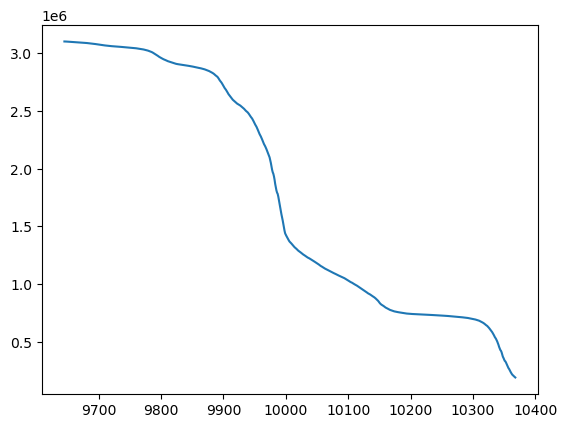

In [16]:
cumulative_cases_in_London = covid_data[covid_data["area"] == "London"]["cumulative_cases"]
cumulative_cases_in_London.plot()

### Task 16

<AxesSubplot:xlabel='date'>

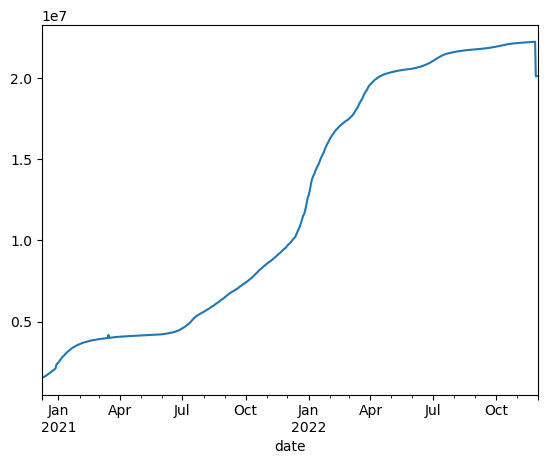

In [17]:
cumulative_cases_summed_over_all_areas = covid_data.groupby("date")["cumulative_cases"].sum()
cumulative_cases_summed_over_all_areas.plot()

### Task 17

<AxesSubplot:xlabel='date'>

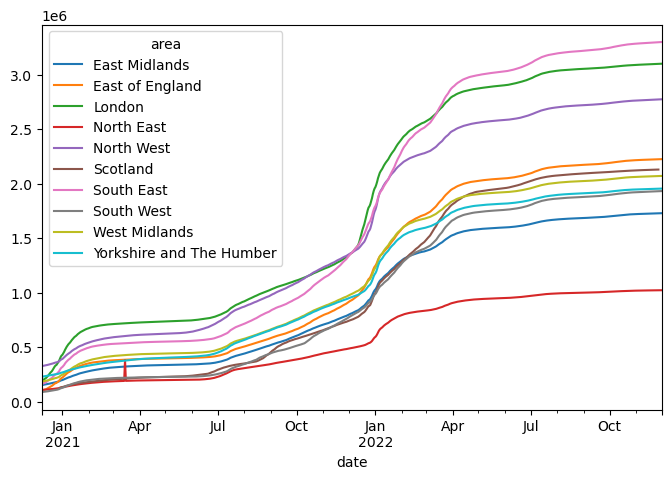

In [18]:
cumulative_cases_of_different_areas = covid_data.groupby(["date","area"])["cumulative_cases"].sum().unstack()
cumulative_cases_of_different_areas.plot(figsize=(8, 5))

### Task 18

### Task 19

<AxesSubplot:xlabel='date'>

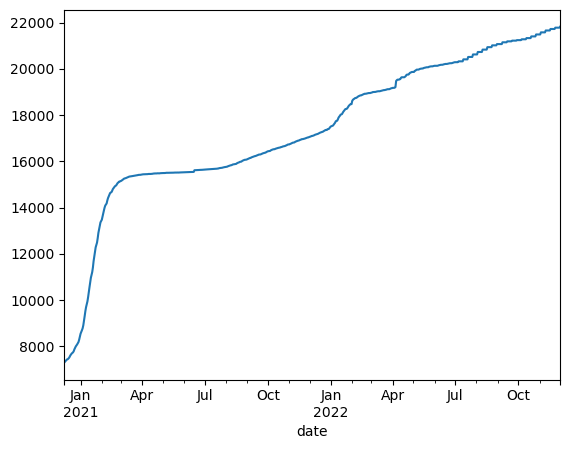

In [19]:
evolution_of_cumulative_deaths_in_London = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_deaths"].sum()
evolution_of_cumulative_deaths_in_London.plot()

### Task 20

### Task 21

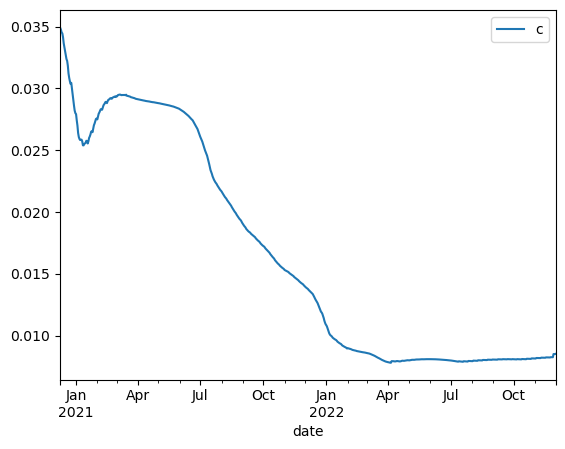

In [32]:
cumulative_deaths_per_cases = covid_data.groupby(["date"])["cumulative_deaths"].sum() / covid_data.groupby("date")["cumulative_cases"].sum()

cumulative_deaths_per_cases.plot()
plt.legend("cumulative_deaths_per_cases")

### Task 22

### Task 23

<AxesSubplot:xlabel='date'>

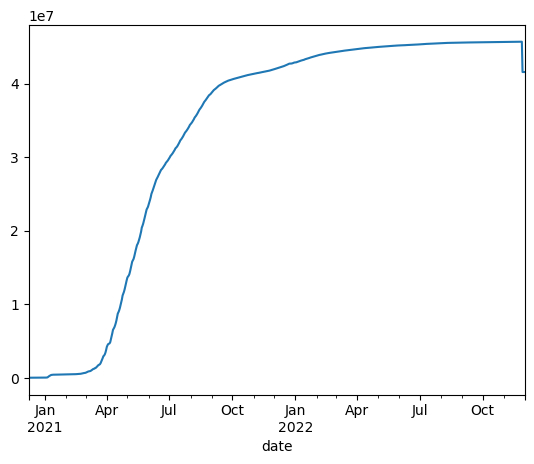

In [21]:
sum_of_cumulative_vaccinations_over_all_areas = covid_data.groupby("date")["cumulative_vaccinated"].sum()
sum_of_cumulative_vaccinations_over_all_areas.plot()

### Task 24

<AxesSubplot:xlabel='date'>

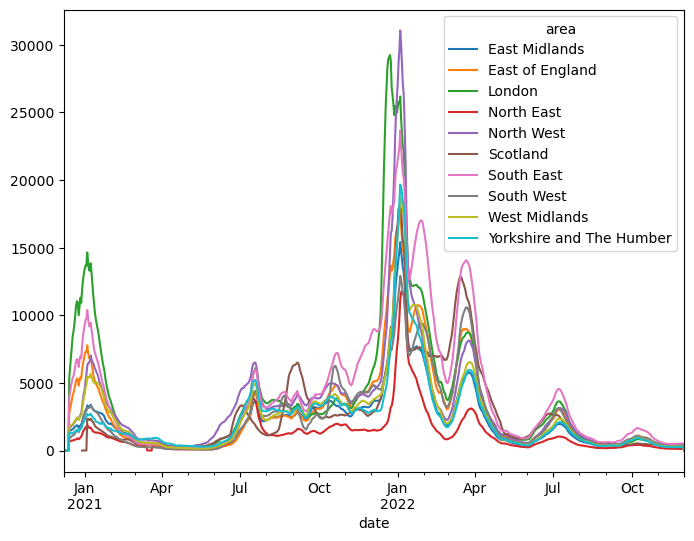

In [22]:
daily_cases_rolling_average_separated_by_areas = covid_data.groupby(["date","area"])["daily_cases_roll_avg"].sum().unstack()
daily_cases_rolling_average_separated_by_areas.plot(figsize=(8, 6))

### Task 25

### Task 26

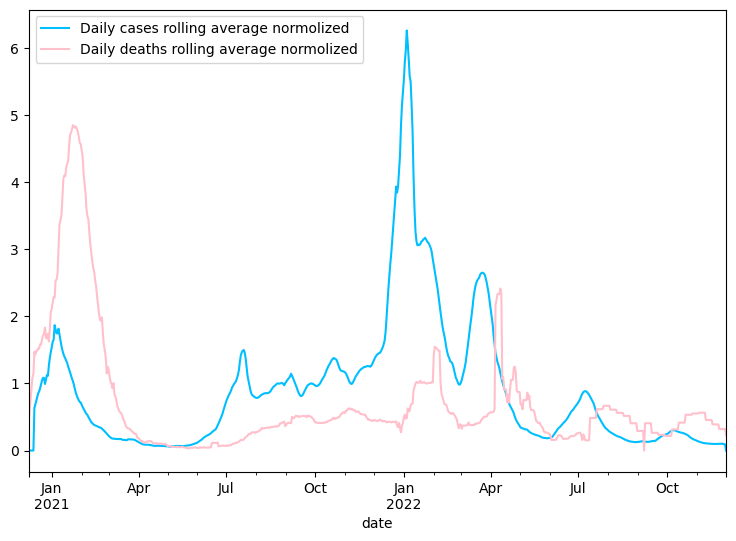

In [55]:
covid_data["daily_cases_roll_avg_norm"] = covid_data["daily_cases_roll_avg"] / covid_data["daily_cases_roll_avg"].max()
covid_data["daily_deaths_roll_avg_norm"] = covid_data["daily_deaths_roll_avg"] / covid_data["daily_deaths_roll_avg"].max()
covid_data.groupby("date")["daily_cases_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "deepskyblue")
covid_data.groupby("date")["daily_deaths_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "pink")
plt.legend(["Daily cases rolling average normolized", "Daily deaths rolling average normolized"])

### Task 27

### Task 28